In [1]:
import os
import sys
import json
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte, io
import cv2
import glob
from typing import Optional, Tuple, Union

# pytorch ops
from pytorch3d.ops import knn_gather, knn_points

In [13]:
def compute_sampling_metrics_2d(pred_points, gt_points, thresholds, eps=1e-8):
    """
    Compute metrics that are based on sampling points from 2D image:
    - L2 Chamfer distance
    - Precision at various thresholds
    - Recall at various thresholds
    - F1 score at various thresholds
    Inputs:
        - pred_points: Tensor of shape (N, S, 3) giving coordinates of sampled points
          for each predicted mesh
        - gt_points: Tensor of shape (N, S, 3) giving coordinates of sampled points
          for each ground-truth mesh
        - thresholds: Distance thresholds to use for precision / recall / F1
        - eps: epsilon value to handle numerically unstable F1 computation
    Returns:
        - metrics: A dictionary where keys are metric names and values are Tensors of
          shape (N,) giving the value of the metric for the batch
    """
    metrics = {}
    lengths_pred = torch.full(
        (pred_points.shape[0],), pred_points.shape[1], dtype=torch.int64, device=pred_points.device
    )
    lengths_gt = torch.full(
        (gt_points.shape[0],), gt_points.shape[1], dtype=torch.int64, device=gt_points.device
    )

    # For each predicted point, find its neareast-neighbor GT point
    knn_pred = knn_points(pred_points, gt_points, lengths1=lengths_pred, lengths2=lengths_gt, K=1)
    # Compute L1 and L2 distances between each pred point and its nearest GT
    pred_to_gt_dists2 = knn_pred.dists[..., 0]  # (N, S)
    pred_to_gt_dists = pred_to_gt_dists2.sqrt()  # (N, S)

    # For each GT point, find its nearest-neighbor predicted point
    knn_gt = knn_points(gt_points, pred_points, lengths1=lengths_gt, lengths2=lengths_pred, K=1)
    # Compute L1 and L2 dists between each GT point and its nearest pred point
    gt_to_pred_dists2 = knn_gt.dists[..., 0]  # (N, S)
    gt_to_pred_dists = gt_to_pred_dists2.sqrt()  # (N, S)


    # Compute L2 chamfer distances
    chamfer_l2 = pred_to_gt_dists2.mean(dim=1) + gt_to_pred_dists2.mean(dim=1)
    metrics["Chamfer-L2"] = chamfer_l2

    # Compute precision, recall, and F1 based on L2 distances
    for t in thresholds:
        precision = 100.0 * (pred_to_gt_dists < t).float().mean(dim=1)
        recall = 100.0 * (gt_to_pred_dists < t).float().mean(dim=1)
        f1 = (2.0 * precision * recall) / (precision + recall + eps)
        metrics["Precision@%f" % t] = precision
        metrics["Recall@%f" % t] = recall
        metrics["F1@%f" % t] = f1

    # Move all metrics to CPU
    metrics = {k: v.cpu() for k, v in metrics.items()}
    return metrics

def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()
    
def get_grayscale_img(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray

def binarize_img(gray_img, threshold):
    _, thresh = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY_INV)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    return thresh

def get_contour(img):
    # want CHAIN_APPROX_NONE because it returns a more full list of points
    contours, hierarchy  = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # grab largest contour (idx 0 i think)
    cnt_idx = 0
    contour = np.squeeze(contours[cnt_idx]) # size: [N x 2]
    return contour

def draw_sampled_points(gray, points):
    radius = 3
    thickness = 3
    contour_img = gray.copy()
    for i in range(points.shape[0]):
        image = cv2.circle(contour_img, tuple(points[i]), radius, [0, 255, 0], thickness)
    return image

### set relevant parameters (replace with path to your files)

In [3]:
# path to two images to compare
img_path1 = 'sample_images/Buildingblock_Ac_1.png'
img_path2 = 'sample_images/#3 Superellipse_Ssh_3.png'

# how many points to sample (if this is great than number of points in im1 or im2's contour it will
# get overrided with the # points of the smaller contour)
n_points_to_sample = 100

### load image (must be square and same size for the rest to make sense!)

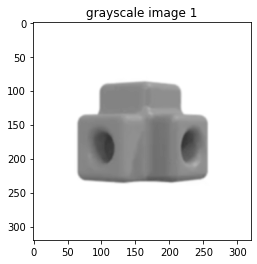

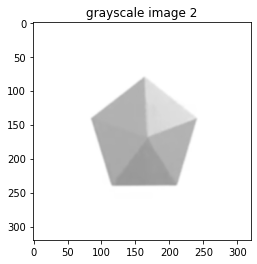

In [21]:
gray1 = get_grayscale_img(img_path1)
gray2 = get_grayscale_img(img_path2)
img_dim = gray1.shape[0] # used later to normalize sampled points, assumes square images

assert gray1.shape == gray2.shape, 'IMAGES MUST BE SAME DIMESIONS'
assert gray1.shape[0] == gray2.shape[1], 'IMAGES MUST BE SQUARE'

plt.imshow(gray1, cmap='gray', vmin=0, vmax=255)
plt.title("grayscale image 1")
plt.show()

plt.imshow(gray2, cmap='gray', vmin=0, vmax=255)
plt.title("grayscale image 2")
plt.show()

### binarize images

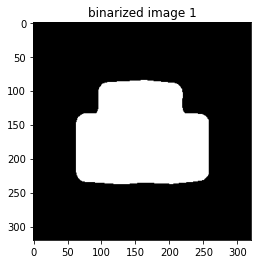

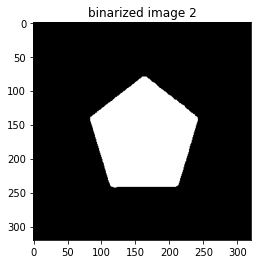

In [5]:
# we know our background is white (pixel) so we set our threshold value close to this
# if you are having issues with the binary image not looking right then play around 
# with the threshold value (try setting it to 254 or 252..)
thresh_val = 250
thresh1 = binarize_img(gray1, thresh_val)
thresh2 = binarize_img(gray2, thresh_val)
plt.imshow(thresh1, cmap='gray', vmin=0, vmax=255)
plt.title("binarized image 1")
plt.show()

plt.imshow(thresh2, cmap='gray', vmin=0, vmax=255)
plt.title("binarized image 2")
plt.show()

## find contour points

found contour on img 1 with 619 points
found contour on img 2 with 458 points
sampling 100 of them


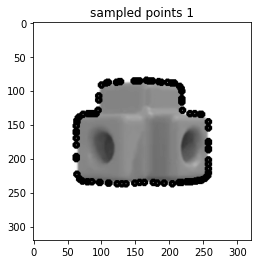

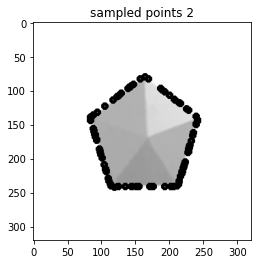

In [6]:
contour1 = get_contour(thresh1)
contour2 = get_contour(thresh2)

n_points1 = contour1.shape[0]
n_points2 = contour2.shape[0]
print('found contour on img 1 with', n_points1, 'points')
print('found contour on img 2 with', n_points2, 'points')
print('sampling', n_points_to_sample, 'of them')
if n_points_to_sample > min(n_points1,n_points2):
    print('not enough points to sample! overriding n_points_to_sample..')
    n_points_to_sample = min(n_points1,n_points2)
    print('sampling', n_points_to_sample, 'now')
    
sampled_idxes = np.random.choice(np.arange(n_points1), n_points_to_sample, replace=False)
sampled_points1 = contour1[sampled_idxes] # size: [n_points_to_sample x 2]
sampled_idxes = np.random.choice(np.arange(n_points2), n_points_to_sample, replace=False)
sampled_points2 = contour2[sampled_idxes] # size: [n_points_to_sample x 2]

vis_points1 = draw_sampled_points(gray1, sampled_points1)
vis_points2 = draw_sampled_points(gray2, sampled_points2)
    
plt.imshow(vis_points1, cmap='gray', vmin=0, vmax=255)
plt.title('sampled points 1')
plt.show()
plt.imshow(vis_points2, cmap='gray', vmin=0, vmax=255)
plt.title('sampled points 2')
plt.show()

### calculate distance metrics

In [24]:
(pts1/img_dim).min()

tensor(0.1969)

In [38]:
thresholds = [0.1, 0.2, 0.5]
pts1 = torch.tensor(sampled_points1).unsqueeze(0) / img_dim # normalize pts to 0-1 range
pts2 = torch.tensor(sampled_points2).unsqueeze(0) / img_dim # normalize pts to 0-1 range
# scale by 10 to be more comparable with meshes (i think?)
pts1 = pts1 * 10.0
pts2 = pts2 * 10.0

result = compute_sampling_metrics_2d(pts1, pts2, thresholds)
print('Chamfer distance:', result['Chamfer-L2'].item()) # lower is better
print('F-score @ 0.1:', result['F1@0.100000'].item()) # higher is better
print('F-score @ 0.2:', result['F1@0.200000'].item()) # higher is better
print('F-score @ 0.5:', result['F1@0.500000'].item()) # higher is better

Chamfer distance: 0.7167675495147705
F-score @ 0.1: 10.0
F-score @ 0.2: 30.870967864990234
F-score @ 0.5: 52.52830123901367
